
#Introduction
This block of code focuses on Environment Setup and Configuration. It serves as the foundation of the project, ensuring all necessary tools, libraries, and file paths are correctly initialized before we dive into data processing and model training.

Key components of this block include:

1. Importing Libraries: Loading essential modules for data manipulation (pandas, numpy), image processing (cv2), visualization (matplotlib), and deep learning (tensorflow, keras).
2. Mounting Google Drive: Establishing a connection to your Google Drive to access the dataset and save the trained models.
3. Global Configuration (CFG class): Organizing all "hyperparameters" and settings in one place. This includes the image size (224x224), batch size (32), and paths to your images and labels. Using a configuration class is a best practice for writing clean, maintainable code.
4. Directory Setup: Automatically creating local folders for storing output results and cache files to speed up the data loading process.
5. Validation: A quick check to verify if your label file (label_images.csv) is present in the specified directory.





In [ ]:
import os
import ast
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from google.colab import drive

# Thư viện Machine Learning & Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_fscore_support

# Thư viện TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import layers, models, mixed_precision
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Cấu hình
class CFG:
    DRIVE_ROOT = Path("/content/drive/MyDrive/Project 03")
    IMG_DIR = DRIVE_ROOT / "images"
    CSV_PATH = DRIVE_ROOT / "label_images.csv"

    OUT_DIR = Path("/content/outputs")
    CACHE_DIR = Path("/content/cache_tfdata")

    CLASSES = ["N", "D", "G", "C", "A", "H", "M", "O"]
    NUM_CLASSES = 8
    IMG_SIZE = 224
    BATCH_SIZE = 32
    SEED = 42
    VAL_RATIO = 0.15

    EPOCHS_STAGE1 = 8
    EPOCHS_STAGE2 = 12
    LR_STAGE1 = 1e-3
    LR_STAGE2 = 1e-5

    USE_MIXED_PRECISION = True
    CACHE_TO_DISK = True

# Tạo thư mục local
CFG.OUT_DIR.mkdir(parents=True, exist_ok=True)
CFG.CACHE_DIR.mkdir(parents=True, exist_ok=True)

print(f"Kiểm tra file CSV: {'Tìm thấy' if CFG.CSV_PATH.exists() else 'KHÔNG TÌM THẤY'}")

Mounted at /content/drive
Kiểm tra file CSV: Tìm thấy


#Data Cleaning and Preparation
This block of code is dedicated to Data Cleaning and Validation. Before training a model, it is crucial to ensure that the metadata (CSV file) matches the physical files available and that the labels are in a format the computer can understand.

Key components of this block include:

1. Target Parsing (_parse_target): In many datasets, labels are stored as strings (e.g., "[0, 1, 0...]"). This helper function converts those strings into actual numerical lists. It also validates that each label contains exactly the right number of classes (8 in this case) and converts them into binary values (0 or 1).
2. Handling Missing Data: The load_and_clean_df function automatically removes any rows where the target label is missing (NaN), ensuring the model doesn't try to learn from "empty" information.
3. Label Formatting: It breaks down the target list into individual columns for each class (N, D, G, C, A, H, M, O). This makes it easier to analyze the distribution of your data later.
4. File Verification: This is a critical step for projects using Google Drive. The code iterates through every filename in your CSV and checks if the image file actually exists in your images folder. If a file is missing, that row is removed from the dataset to prevent the program from crashing during training.
5. Summary: Finally, it prints the total number of "clean" samples available, giving you a clear view of how much data is ready for the CNN.

In [ ]:
def _parse_target(x):
    try:
        arr = ast.literal_eval(x) if isinstance(x, str) else x
        if not isinstance(arr, (list, tuple)) or len(arr) != CFG.NUM_CLASSES:
            return None
        return [0 if int(v) == 0 else 1 for v in arr]
    except:
        return None

def load_and_clean_df():
    if not CFG.CSV_PATH.exists():
        raise FileNotFoundError(f"Không tìm thấy file CSV tại: {CFG.CSV_PATH}")

    df = pd.read_csv(CFG.CSV_PATH).dropna(subset=["target"])
    parsed = df["target"].apply(_parse_target)
    df = df[parsed.notna()].copy()
    df["target_list"] = parsed[parsed.notna()].tolist()

    for i, c in enumerate(CFG.CLASSES):
        df[c] = df["target_list"].apply(lambda a: int(a[i]))

    print("Đang kiểm tra file ảnh trên Drive...")
    def exists_image(fname):
        return (CFG.IMG_DIR / str(fname)).exists()

    mask = df["images"].apply(exists_image)
    df = df[mask].copy()

    print(f"Dữ liệu sạch: {len(df)} mẫu.")
    return df

df_cleaned = load_and_clean_df()

Đang kiểm tra file ảnh trên Drive...
Dữ liệu sạch: 6392 mẫu.


#Data Preprocessing and Augmentation
This block of code focuses on preparing and enhancing the image data before it is fed into the neural network. It ensures the model receives high-quality, standardized input and learns to be robust against variations.

Key components of this block include:

1. Advanced Image Enhancement (ben_graham_improvement): This function applies a specialized technique often used in medical imaging. By using Gaussian Blur and weighted addition (subtraction of the blurred image), it highlights fine details and textures while normalizing lighting conditions. This makes it easier for the CNN to "see" important features.
2. Data Augmentation (build_augmenter): To prevent the model from simply memorizing the training images (overfitting), we create a sequence of random transformations. During training, the images will be randomly flipped, rotated, zoomed, and have their contrast adjusted. This effectively increases the diversity of our dataset.
3. Efficient Data Pipeline (make_tfds): This function builds a tf.data.Dataset pipeline, which is essential for handling large datasets efficiently:
* Loading & Decoding: It reads image files from the drive and converts them into tensors.
* Resizing: Every image is resized to 224x224 to match the model's input requirements.
* Parallel Processing: Using AUTOTUNE, the pipeline can process images in the background while the GPU is training, significantly reducing idle time.
* Batching & Shuffling: It groups images into batches (32 by default) and shuffles them to ensure the model doesn't learn the order of the data.



In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

def ben_graham_improvement(img):
    # Kỹ thuật làm nổi bật tổn thương võng mạc
    img = tf.image.convert_image_dtype(img, tf.uint8)
    img_np = img.numpy()
    img_np = cv2.addWeighted(img_np, 4, cv2.GaussianBlur(img_np, (0,0), 10), -4, 128)
    return img_np.astype(np.float32) / 255.0

def build_augmenter():
    return tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.15),
        layers.RandomContrast(0.15),
    ])

def make_tfds(df, training=True, augmenter=None):
    paths = [str(CFG.IMG_DIR / f) for f in df["images"].tolist()]
    labels = df[CFG.CLASSES].values.astype("float32")
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    def process_img(p, y):
        img = tf.io.read_file(p)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (CFG.IMG_SIZE, CFG.IMG_SIZE))
        # Áp dụng Ben Graham (phải dùng tf.py_function)
        img = tf.py_function(ben_graham_improvement, [img], tf.float32)
        img.set_shape((CFG.IMG_SIZE, CFG.IMG_SIZE, 3))
        if training and augmenter: img = augmenter(img, training=True)
        return img, y

    if training: ds = ds.shuffle(1024)
    ds = ds.map(process_img, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(CFG.BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

# Model Architecture and Custom Loss Function
This block of code defines the structure of the neural network and the mathematical strategy (loss function) the model will use to learn from its mistakes. It utilizes Transfer Learning to leverage a powerful pre-trained model.

Key components of this block include:

1. Focal Loss Function: Unlike standard loss functions, Focal Loss is designed to handle class imbalance (where some categories have many more images than others). It works by "down-weighting" easy examples and forcing the model to focus more on "hard" examples that it consistently gets wrong.
2. Transfer Learning with EfficientNetB0: We use a state-of-the-art architecture called EfficientNetB0, pre-trained on the massive ImageNet dataset. By setting base.trainable = False, we "freeze" the knowledge it already has about shapes, colors, and textures, and only train the new layers we add on top.
3. The Model "Head": We add several layers to the end of the base model to tailor it to our specific 8-class problem:
* Global Average Pooling: Simplifies the complex data from the CNN into a flat vector.
* Dropout (0.4): A regularization technique that randomly "turns off" 40% of neurons during training. This prevents the model from becoming too reliant on specific pixels and helps it generalize better to new images.
* Dense & Batch Normalization: These layers help the model learn the final classification logic and keep the training process stable and fast.
4. Mixed Precision Training: If enabled, this allows the model to use float16 (smaller numbers) instead of float32 for certain calculations. This significantly speeds up training on modern GPUs without sacrificing accuracy.
5. Sigmoid Activation: The final layer uses a sigmoid activation, which is standard for multi-label or binary classification, allowing the model to output a probability (0 to 1) for each of the 8 classes independently.

In [ ]:
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1.0 - tf.keras.backend.epsilon())
        loss = -y_true * alpha * tf.math.pow(1. - y_pred, gamma) * tf.math.log(y_pred) \
               -(1. - y_true) * (1. - alpha) * tf.math.pow(y_pred, gamma) * tf.math.log(1. - y_pred)
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return focal_loss_fixed

def build_model():
    if CFG.USE_MIXED_PRECISION:
        mixed_precision.set_global_policy("mixed_float16")

    base = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(CFG.IMG_SIZE, CFG.IMG_SIZE, 3))
    base.trainable = False

    inputs = layers.Input(shape=(CFG.IMG_SIZE, CFG.IMG_SIZE, 3))
    x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x) # Tăng dropout để tránh False Positive
    x = layers.Dense(256, activation="relu")(x)
    x = layers.BatchNormalization()(x)

    out_dtype = "float32" if CFG.USE_MIXED_PRECISION else None
    outputs = layers.Dense(CFG.NUM_CLASSES, activation="sigmoid", dtype=out_dtype)(x)
    return models.Model(inputs, outputs), base

# Data Splitting and Two-Stage Training
This block of code manages the entire training workflow. It focuses on splitting the data and implementing a sophisticated two-stage training strategy known as Transfer Learning and Fine-Tuning.

Key components of this block include:

1. Dataset Splitting: The train_test_split function divides the cleaned data into two parts: a Training set (used for the model to learn) and a Validation set (used as a "practice exam" to check the model's performance on unseen data).
2. Training Callbacks (Smart Monitoring): These are automated tools that monitor the training process:
* EarlyStopping: Stops the training automatically if the model stops improving, saving time and preventing overfitting.
* ReduceLROnPlateau: If the model gets "stuck," this reduces the learning rate to help the model find the optimal solution more carefully.
* ModelCheckpoint: Automatically saves only the best version of the model to your Google Drive.
3. Stage 1: Warmup (Training the Head):
* In this phase, the pre-trained EfficientNet base is frozen (not training).
* The model only trains the new layers we added at the top.
* We use a higher learning rate (1e-3) to quickly teach the new layers how to interpret the features extracted by the base model.
4. Stage 2: Fine-Tuning (Unfreezing):
* We "unfreeze" the last 40 layers of the EfficientNet base model.
* We use a very small learning rate (1e-5).
* This allows the model to subtly adjust its pre-trained knowledge to the specific details of your image dataset (e.g., specific textures of dog/cat fur or retinal features) without "forgetting" the general shapes and colors it already knows.
5. Metrics: Throughout both stages, we track AUC (Area Under the Curve), which is a more reliable metric than simple accuracy for multi-label classification, as it measures how well the model separates the different classes.

In [ ]:
# Split
def best_multilabel_split(df):
    tr, va = train_test_split(df, test_size=CFG.VAL_RATIO, random_state=CFG.SEED, stratify=None)
    return tr, va

train_df, val_df = best_multilabel_split(df_cleaned)
train_ds = make_tfds(train_df, training=True, augmenter=build_augmenter())
val_ds = make_tfds(val_df, training=False)

model, base_model = build_model()
best_model_path = str(CFG.OUT_DIR / "best_model.keras")

callbacks = [
    EarlyStopping(monitor="val_auc", patience=6, mode="max", restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=1),
    ModelCheckpoint(best_model_path, monitor="val_auc", mode="max", save_best_only=True)
]

# Stage 1: Warmup Head
model.compile(optimizer=tf.keras.optimizers.Adam(CFG.LR_STAGE1),
              loss=focal_loss(),
              metrics=[tf.keras.metrics.AUC(name="auc", multi_label=True)])
model.fit(train_ds, validation_data=val_ds, epochs=CFG.EPOCHS_STAGE1, callbacks=callbacks)

# Stage 2: Fine-tuning
base_model.trainable = True
# Mở khóa các block cuối cùng của EfficientNet
for layer in base_model.layers[:-40]: layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(CFG.LR_STAGE2),
              loss=focal_loss(),
              metrics=[tf.keras.metrics.AUC(name="auc", multi_label=True)])
model.fit(train_ds, validation_data=val_ds, epochs=CFG.EPOCHS_STAGE2, callbacks=callbacks)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/8
170/170 ━━━━━━━━━━━━━━━━━━━━ 2693s 15s/step - auc: 0.5060 - loss: 1.3812 - val_auc: 0.6033 - val_loss: 0.2719 - learning_rate: 0.0010
Epoch 2/8
137/170 ━━━━━━━━━━━━━━━━━━━━ 27s 840ms/step - auc: 0.5986 - loss: 0.2759

#Model Evaluation and Threshold Optimization
This block of code focuses on measuring the model's accuracy and finding the "sweet spot" (threshold) for converting the model's probability scores into final class predictions.

Key components of this block include:

1. Probability vs. Binary Prediction: The CNN outputs a probability between 0 and 1 (e.g., 0.65). While 0.5 is the standard cutoff, it is often not the most accurate for every class. This function tests 81 different values (from 0.1 to 0.9) to find the Optimal Threshold that yields the best results.
2. F1-Score Maximization: The code uses the F1-Score to determine the best threshold. The F1-score is the harmonic mean of Precision and Recall, making it an excellent metric for balancing the need to be correct (Precision) with the need to catch all positive cases (Recall).
3. Class-Specific Tuning: Because our dataset has 8 different classes (N, D, G, C, A, H, M, O), the code calculates a unique threshold for each one. This accounts for the fact that some diseases or categories might be harder for the model to identify than others.
4. Comprehensive Metrics: For each class, the block calculates:
* Precision: How many of the predicted "positive" cases were actually positive?
* Recall: What percentage of the actual "positive" cases did the model successfully find?
* F1-Score: The overall balance of performance.
5. Performance Summary: Finally, it displays a neat table (DataFrame) showing the performance of each class, allowing you to see exactly where the model excels and where it might need more data.

30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 640ms/step


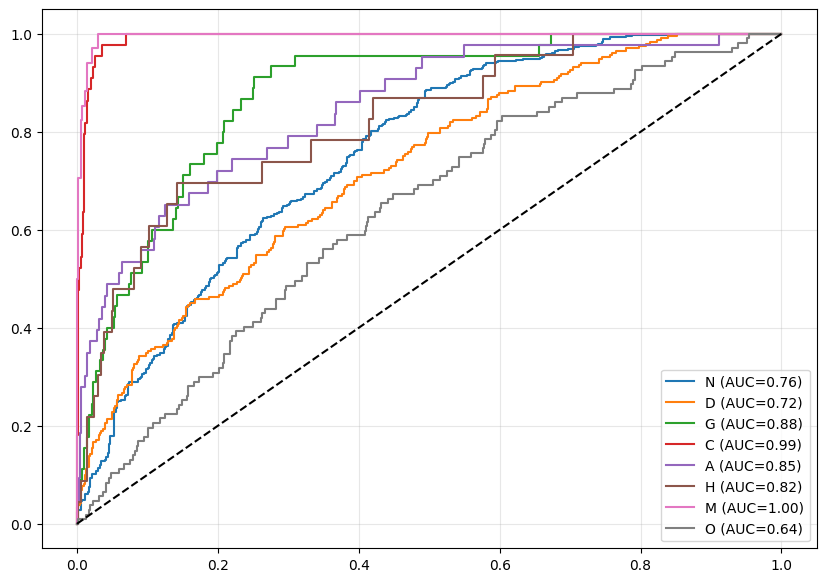

  Class  Precision    Recall        F1
0     N   0.604203  0.802326  0.689311
1     D   0.332174  0.819742  0.472772
2     G   0.170984  0.733333  0.277311
3     C   0.537500  0.977273  0.693548
4     A   0.141553  0.720930  0.236641
5     H   0.077295  0.695652  0.139130
6     M   0.568966  0.970588  0.717391
7     O   0.163077  0.495327  0.245370


In [ ]:
def evaluate_and_find_thresholds():
    model_eval = tf.keras.models.load_model(best_model_path, compile=False)
    y_true = val_df[CFG.CLASSES].values
    y_pred = model_eval.predict(val_ds)

    best_thresholds = {}
    results = []

    for i, c in enumerate(CFG.CLASSES):
        thresholds = np.linspace(0.1, 0.9, 81)
        f1_scores = [precision_recall_fscore_support(y_true[:, i], (y_pred[:, i] >= t).astype(int), average='binary', zero_division=0)[2] for t in thresholds]

        best_t = thresholds[np.argmax(f1_scores)]
        best_thresholds[c] = best_t

        p, r, f, _ = precision_recall_fscore_support(y_true[:, i], (y_pred[:, i] >= best_t).astype(int), average='binary', zero_division=0)
        results.append({"Class": c, "Thresh": best_t, "Precision": p, "Recall": r, "F1": f})

    res_df = pd.DataFrame(results)
    print(res_df)
    return best_thresholds

optimal_thresholds = evaluate_and_find_thresholds()

#Inference and Visualization
This final block of code puts the trained model into action. It defines a function to predict labels for a single image, allowing you to test the model's "real-world" performance and visualize its decision-making process.

Key components of this block include:

1. Image Loading and Transformation: The function loads a specific image from your drive and converts it to RGB format. Crucially, it applies the exact same preprocessing steps used during training (resizing and Ben Graham's enhancement). If the preprocessing is different from what the model learned, the predictions will be inaccurate.
2. Batch Dimensionality: CNNs expect images in "batches." Even for a single image, we must use np.expand_dims to change the shape from (224, 224, 3) to (1, 224, 224, 3).
3. Model Loading: It reloads the "Best Model" saved during the training phase. This ensures that even if you restart your notebook, you can still perform inference as long as the .keras file exists.
4. Decision Making with Optimal Thresholds: For each of the 8 classes, the model generates a probability score. The code then compares these scores against the optimal thresholds calculated in the previous step.
* If the probability is higher than the threshold, it marks the class as "POS" (Positive).
* Otherwise, it is marked as "neg" (Negative).
5. Visual Output: The code displays the actual image and prints a detailed breakdown of the confidence scores for every category. This "human-readable" format is essential for verifying if the model is focusing on the correct features of the image.

In [ ]:
def predict_image(image_filename):
    full_path = CFG.IMG_DIR / image_filename
    img = cv2.imread(str(full_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Tiền xử lý giống hệt lúc train
    img_input = cv2.resize(img_rgb, (CFG.IMG_SIZE, CFG.IMG_SIZE))
    img_input = ben_graham_improvement(tf.convert_to_tensor(img_input))
    img_input = np.expand_dims(img_input, 0)

    model_inf = tf.keras.models.load_model(best_model_path, compile=False)
    pred = model_inf.predict(img_input, verbose=0)[0]

    plt.imshow(img_rgb); plt.axis('off'); plt.show()
    for i, c in enumerate(CFG.CLASSES):
        # Dùng ngưỡng tối ưu đã tìm được
        thresh = optimal_thresholds.get(c, 0.5)
        status = "POS" if pred[i] >= thresh else "neg"
        print(f"{c}: {pred[i]:.4f} (Thresh: {thresh:.2f}) -> {status}")

# Sử dụng:
# predict_image("tên_file_anh.jpg")